## Contents
0. Import Libraries and Load Data
1. Data Preparation for PanelData Model
2. Bassic Panel Model
    - PooledOLS model
    - RandomEffects model
    - BetweenOLS model
3. Testing correlated effects
    - Testing for Fixed Effects
    - Testing for Time Effects
    - First Differences
4. Comparison
    - Comparing between modelBetween, modelRE and modelPooled models
    - Comparing between Robust, Entity and Entity-Time mothods
    
5. Instruments as lags of order 1 and 2 of first differences
    - Campute the lags of order 1 and 2 of first differences
6. Linear Instrumental-Variables Regression
    - 2SLS as OLS
    - IV 2SLS
    - Tests
        - Sargan test: Testing the absence of correlation between Z and U
        - Testing the correlation of Z and X_endog
        - Endogeneity testing using `Durbin's and Wu-Hausman test of exogeneity
        - Augmented test for testing the exogeneity `log_fare`
        - Instrumenting using two-stage least squares
        - Homoskedasticity – Heteroskedasticity
            - Breusch–Pagan test
            - White test
7. GMM Estimation
8.1. Exogeneity test using the augmented regression approach
8.2. Testing Autocorrelation
9. Feasible Generalized Least Squares (GLS) and GLSA model
10. References  

In [1]:
# Importning libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

import glob
from glob import iglob
import datetime as dt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

from linearmodels import PanelOLS, PooledOLS, BetweenOLS, RandomEffects, FirstDifferenceOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence

%matplotlib inline

In [2]:
path = '../notebooks/final_database.csv'
df = pd.read_csv(path, decimal='.', sep=',')

df['quarter'] = pd.to_datetime(df.quarter).dt.to_period('Q-DEC')
df.sort_values(['citymarket1_id', 'citymarket2_id','quarter'], inplace=True)

df.head()

,quarter,citymarket1_id,citymarket2_id,city1_name,city2_name,nsmiles,passengers,fare,latitude_city1,longitude_city1,...,dum_q3,dum_q4,dum_dist,log_passengers,log_nsmiles,log_fare,log_income,log_income_capita,log_population,log_kjf_price
13,2010Q1,30135,30194,Allentown/Bethlehem/Easton,Dallas/Fort Worth,1308,28,214.94,40.602753,-75.469759,...,0,0,0,3.332205,7.176255,5.370359,13.499864,10.576317,16.754431,5.371878
3041,2010Q2,30135,30194,Allentown/Bethlehem/Easton,Dallas/Fort Worth,1308,42,235.15,40.602753,-75.469759,...,0,0,0,3.737670,7.176255,5.460224,13.520416,10.594457,16.757335,5.428614
9461,2010Q4,30135,30194,Allentown/Bethlehem/Easton,Dallas/Fort Worth,1308,64,189.38,40.602753,-75.469759,...,0,1,0,4.158883,7.176255,5.243756,13.553289,10.620949,16.763388,5.497988
18904,2011Q3,30135,30194,Allentown/Bethlehem/Easton,Dallas/Fort Worth,1307,47,243.50,40.602753,-75.469759,...,1,0,0,3.850148,7.175490,5.495117,13.614625,10.669920,16.771834,5.748118
28355,2012Q2,30135,30194,Allentown/Bethlehem/Easton,Dallas/Fort Worth,1307,39,275.34,40.602753,-75.469759,...,0,0,0,3.663562,7.175490,5.618007,13.660492,10.704951,16.780740,5.732370


## Preparing the `PanelData` 
- To use the data as `PanelData`, we need:
    - to campute a dummies variable for each period (quarter, in our case),
    - to identify the ID variable and the time variable, and then to set them in index,
    - to sort the data to respect to the `ID`and the `period`.
    
- As the `Within` and the `First Difference` (respectively the `Second Difference`) estimators require at least 2 (respectively 4) observations per individual, we will delete the lines with only one, two and tree observations in the dataset.
- To do so, we will first campute the frequency of the `city market` in each quarter (here: number of quarter by city market) and then keep only the those are present in that dataset `at least 4 times`.

In [3]:
variables = ['log_passengers','log_nsmiles','log_fare','nb_airline','log_income_capita','log_population',
             'log_kjf_price','dum_dist' ,'dum_q1','dum_q2','dum_q3','dum_q4']

df['citymarket_id'] = df.citymarket1_id.astype(str)+'_'+df.citymarket2_id.astype(str)
df['quarter_index'] = (df.quarter.dt.year.astype(str)+df.quarter.dt.quarter.astype(str)).astype(int)

panel0_df = df[['citymarket_id','quarter_index', 'quarter']+variables].copy()
panel0_df.sort_values(['citymarket_id','quarter_index'], inplace=True)
print('panel0_df has {} observations and {} variables'.format(panel0_df.shape[0], panel0_df[variables].shape[1]))

panel0_df has 101236 observations and 12 variables


In [4]:
# Reset the index in order to campute the number of quarter by city market
# panel0_df.reset_index(inplace=True)

# Compute the dummies variables of quarter
panel0_df['quarter'] = pd.Categorical(panel0_df.quarter)

panel0_df.head()

,citymarket_id,quarter_index,quarter,log_passengers,log_nsmiles,log_fare,nb_airline,log_income_capita,log_population,log_kjf_price,dum_dist,dum_q1,dum_q2,dum_q3,dum_q4
13,30135_30194,20101,2010Q1,3.332205,7.176255,5.370359,2,10.576317,16.754431,5.371878,0,1,0,0,0
3041,30135_30194,20102,2010Q2,3.737670,7.176255,5.460224,1,10.594457,16.757335,5.428614,0,0,1,0,0
9461,30135_30194,20104,2010Q4,4.158883,7.176255,5.243756,1,10.620949,16.763388,5.497988,0,0,0,0,1
18904,30135_30194,20113,2011Q3,3.850148,7.175490,5.495117,1,10.669920,16.771834,5.748118,0,0,0,1,0
28355,30135_30194,20122,2012Q2,3.663562,7.175490,5.618007,2,10.704951,16.780740,5.732370,0,0,1,0,0


In [5]:
# Campute and save the number of quarter by city market
nb_cm = panel0_df[['citymarket_id', 'quarter']].groupby(['citymarket_id']).nunique()
nb_cm.drop('citymarket_id', axis=1, inplace=True)

# Reset the index and rename the columns in order to merge the two datasets
nb_cm.reset_index(inplace=True)
nb_cm.columns = ['citymarket_id','nb_citymarket']

# Merging and dropping the no needed rows
panel1_df = pd.merge(panel0_df, nb_cm, on=['citymarket_id'], how='inner')
panel1_df = panel1_df[panel1_df.nb_citymarket>=4]
panel1_df.drop('nb_citymarket', axis=1, inplace=True)

print("We delete {} city-markets(lines) which didn't present at least 4 times in a given querter.".format(panel0_df.shape[0]-panel1_df.shape[0]))
print("So now, we have '{}' obserations in our dataset which will be used to camput the first and second differences.\n".format(panel1_df.shape[0]))

print('We have {} uniques city-pair  markets and {} periods on our dataset'.format(panel1_df.citymarket_id.nunique(),
                                                                                    panel1_df.quarter.nunique()))

We delete 2563 city-markets(lines) which didn't present at least 4 times in a given querter.
So now, we have '98673' obserations in our dataset which will be used to camput the first and second differences.

We have 4578 uniques city-pair  markets and 33 periods on our dataset


In [6]:
# Assign the city-market ID a new variable name `ID`
iden = panel1_df[['citymarket_id', 'quarter']].groupby(['citymarket_id']).nunique()
iden['ID'] = range(1, iden.shape[0]+1)
iden.drop('citymarket_id', axis=1, inplace=True)
iden.reset_index(inplace=True)
iden = iden[['citymarket_id', 'ID']]
panel1_df = pd.merge(iden, panel0_df, on=['citymarket_id'], how='inner')

panel1_df.head()

,citymarket_id,ID,quarter_index,quarter,log_passengers,log_nsmiles,log_fare,nb_airline,log_income_capita,log_population,log_kjf_price,dum_dist,dum_q1,dum_q2,dum_q3,dum_q4
0,30135_30194,1,20101,2010Q1,3.332205,7.176255,5.370359,2,10.576317,16.754431,5.371878,0,1,0,0,0
1,30135_30194,1,20102,2010Q2,3.737670,7.176255,5.460224,1,10.594457,16.757335,5.428614,0,0,1,0,0
2,30135_30194,1,20104,2010Q4,4.158883,7.176255,5.243756,1,10.620949,16.763388,5.497988,0,0,0,0,1
3,30135_30194,1,20113,2011Q3,3.850148,7.175490,5.495117,1,10.669920,16.771834,5.748118,0,0,0,1,0
4,30135_30194,1,20122,2012Q2,3.663562,7.175490,5.618007,2,10.704951,16.780740,5.732370,0,0,1,0,0


In [7]:
panel1_df.citymarket_id.nunique(), panel1_df.citymarket_id.count()

(4578, 98673)

In [8]:
panel1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98673 entries, 0 to 98672
Data columns (total 16 columns):
citymarket_id        98673 non-null object
ID                   98673 non-null int64
quarter_index        98673 non-null int64
quarter              98673 non-null category
log_passengers       98673 non-null float64
log_nsmiles          98673 non-null float64
log_fare             98673 non-null float64
nb_airline           98673 non-null int64
log_income_capita    98673 non-null float64
log_population       98673 non-null float64
log_kjf_price        98673 non-null float64
dum_dist             98673 non-null int64
dum_q1               98673 non-null int64
dum_q2               98673 non-null int64
dum_q3               98673 non-null int64
dum_q4               98673 non-null int64
dtypes: category(1), float64(6), int64(8), object(1)
memory usage: 12.1+ MB


In [9]:
print('Number of city-market:', panel1_df.citymarket_id.nunique(), 
      '\nNumber of quarter:', panel1_df.quarter.nunique())

Number of city-market: 4578 
Number of quarter: 33


## Basic regression
- First, run the PooledOLS as classical OLS regression to check the structure of the data .
- The log passengers is modeled using all independent variables and time dummies. 
- `Note` that the dummies of quarters will not used at the same time with the dummies of times
https://bashtage.github.io/linearmodels/devel/panel/examples/examples.html

In [10]:
# the index in order to campute the number of quarter by city market
panel1_df.set_index(['citymarket_id','quarter_index'], inplace=True)


### Parameters
- `time_effects`: flag whether to include entity (fixed) effects in the model, if `True`
- `time_effects`: flag whether to include time effects in the model, if `True`
- `cov_type`:
    - if `homoskedastic` or `unadjusted`: assume residual are homoskedastic
    - if `heteroskedastic` or `robust`: control for heteroskedasticity using `White’s estimator`    
- White’s robust covariance adds some robustness against certain types of specification issues. This estimator should not be used when including fixed effects (entity effects) because, no longer robust.

### 1. PooledOLS model

In [11]:
# Identifying the regressors. Note that the `quarter` is the time dummies 
regressors = ['log_nsmiles','log_fare','nb_airline','log_income_capita','log_population','log_kjf_price','dum_dist','quarter']

modelPooled = PanelOLS(panel1_df.log_passengers, panel1_df[regressors], 
                       entity_effects=False, time_effects=False, other_effects=None)
modelPooled = modelPooled.fit(cov_type='robust')
print(modelPooled)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_passengers   R-squared:                        0.4885
Estimator:                   PanelOLS   R-squared (Between):              0.5208
No. Observations:               98673   R-squared (Within):              -1.1120
Date:                Thu, Jan 16 2020   R-squared (Overall):              0.4885
Time:                        17:32:32   Log-likelihood                 -1.21e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2478.5
Entities:                        4578   P-value                           0.0000
Avg Obs:                       21.554   Distribution:                F(38,98634)
Min Obs:                       4.0000                                           
Max Obs:                       33.000   F-statistic (robust):             2780.5
                            

In [12]:
modelPooled.f_pooled

Irrelevant test statistic
Model has no effects
Pooled F-stat
InapplicableTestStatistic, id: 0x1c257f0a20

In [13]:
modelPooled.entity_info

mean        21.553735
median      24.000000
max         33.000000
min          4.000000
total     4578.000000
Name: Observations per entity, dtype: float64

In [14]:
modelPooled.f_statistic

Model F-statistic (homoskedastic)
H0: All parameters ex. constant not zero
Statistic: 2478.5311
P-value: 0.0000
Distributed: F(38,98634)
WaldTestStatistic, id: 0x1c25947978

In [15]:
modelPooled.f_statistic_robust

Model F-statistic (robust)
H0: All parameters ex. constant not zero
Statistic: 2780.4962
P-value: 0.0000
Distributed: F(38,98634)
WaldTestStatistic, id: 0x1c28fd5ef0

In [16]:
modelPooled.variance_decomposition

Effects                   0.000000
Residual                  0.679835
Percent due to Effects    0.000000
Name: Variance Decomposition, dtype: float64

In [17]:
"""modelRE.f_statistic
modelRE.f_statistic_robust
modelRE.variance_decomposition"""

'modelRE.f_statistic\nmodelRE.f_statistic_robust\nmodelRE.variance_decomposition'

### 2. RandomEffects model

In [18]:
# Identifying the regressors. Note that the `quarter` is the time dummies 
regressors = ['log_nsmiles','log_fare','nb_airline','log_income_capita','log_population','log_kjf_price','dum_dist', 'quarter']

modelRE = RandomEffects(panel1_df.log_passengers, panel1_df[regressors])
modelRE = modelRE.fit(cov_type='robust')
print(modelRE)

                        RandomEffects Estimation Summary                        
Dep. Variable:         log_passengers   R-squared:                        0.2337
Estimator:              RandomEffects   R-squared (Between):              0.1783
No. Observations:               98673   R-squared (Within):               0.2486
Date:                Thu, Jan 16 2020   R-squared (Overall):              0.1187
Time:                        17:32:33   Log-likelihood                    3303.8
Cov. Estimator:                Robust                                           
                                        F-statistic:                      791.38
Entities:                        4578   P-value                           0.0000
Avg Obs:                       21.554   Distribution:                F(38,98634)
Min Obs:                       4.0000                                           
Max Obs:                       33.000   F-statistic (robust):             2061.9
                            

In [19]:
modelRE.variance_decomposition

Effects                   0.514189
Residual                  0.052061
Percent due to Effects    0.908060
Name: Variance Decomposition, dtype: float64

In [20]:
modelRE.theta.head()

,theta
citymarket_id,
30135_30194,0.925211
30135_30198,0.871180
30135_30325,0.894526
30135_30397,0.944694
30135_30466,0.899883


### 2. BetweenOLS model
The quarter dummies are dropped since the averaging removes differences due to the quarter. These results are broadly similar to the previous models.

In [21]:
# Identifying the regressors. Note that the `quarter` is the time dummies 
panel1_df['const'] = 1
regressors = ['const','log_nsmiles','log_fare','nb_airline','log_income_capita','log_population','log_kjf_price','dum_dist'] # , 'quarter'

modelBetween = BetweenOLS(panel1_df.log_passengers, panel1_df[regressors])
modelBetween = modelBetween.fit(cov_type='robust')

print(modelBetween)

                         BetweenOLS Estimation Summary                          
Dep. Variable:         log_passengers   R-squared:                        0.5996
Estimator:                 BetweenOLS   R-squared (Between):              0.5996
No. Observations:                4578   R-squared (Within):              -2.6978
Date:                Thu, Jan 16 2020   R-squared (Overall):              0.3986
Time:                        17:32:34   Log-likelihood                   -5047.5
Cov. Estimator:                Robust                                           
                                        F-statistic:                      977.62
Entities:                        4578   P-value                           0.0000
Avg Obs:                       21.554   Distribution:                  F(7,4570)
Min Obs:                       4.0000                                           
Max Obs:                       33.000   F-statistic (robust):             733.95
                            

## Testing correlated effects
> When effects are correlated with the regressors the RE and BE estimators are not consistent. The usual solution is to use Fixed Effects which are available in PanelOLS. Fixed effects are called entity_effects when applied to entities and time_effects when applied to the time dimension:

### 1. Testing for Fixed Effects
- Entity effects can be added using `entity_effects=True`. 
- Time-invariant (`dum_dist`) variable is excluded when using entity effects since it will all be 0.
- Since the estimator is not robust, we set `cov_type='clustered'.

In [22]:
regressors = ['log_nsmiles','log_fare','nb_airline','log_income_capita','log_population','log_kjf_price', 'quarter']

modelFE = PanelOLS(panel1_df.log_passengers, panel1_df[regressors], 
                       entity_effects=True, time_effects=False, other_effects=None)
modelFE = modelFE.fit(cov_type='clustered', cluster_entity=True)
print(modelFE)


                          PanelOLS Estimation Summary                           
Dep. Variable:         log_passengers   R-squared:                        0.2493
Estimator:                   PanelOLS   R-squared (Between):              0.0204
No. Observations:               98673   R-squared (Within):               0.2493
Date:                Thu, Jan 16 2020   R-squared (Overall):              0.1339
Time:                        17:32:35   Log-likelihood                    8159.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      844.43
Entities:                        4578   P-value                           0.0000
Avg Obs:                       21.554   Distribution:                F(37,94058)
Min Obs:                       4.0000                                           
Max Obs:                       33.000   F-statistic (robust):             2093.5
                            

### 2. Testing for Time Effects
- Time effect can be added using `time_effects=True`. 
- Here, when we include or exclude the constant, we have the same results.

In [23]:
regressors = ['const','log_nsmiles','log_fare','nb_airline','log_income_capita','log_population']

modelTE = PanelOLS(panel1_df.log_passengers, panel1_df[regressors], 
                       entity_effects=False, time_effects=True, other_effects=None)
modelTE = modelTE.fit(cov_type='clustered', cluster_entity=True, cluster_time=True) 
print(modelTE)


                          PanelOLS Estimation Summary                           
Dep. Variable:         log_passengers   R-squared:                        0.4833
Estimator:                   PanelOLS   R-squared (Between):              0.5147
No. Observations:               98673   R-squared (Within):              -1.1651
Date:                Thu, Jan 16 2020   R-squared (Overall):              0.4808
Time:                        17:32:35   Log-likelihood                -1.214e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.845e+04
Entities:                        4578   P-value                           0.0000
Avg Obs:                       21.554   Distribution:                 F(5,98635)
Min Obs:                       4.0000                                           
Max Obs:                       33.000   F-statistic (robust):             1143.3
                            

### 3. First Differences
> First differencing is an alternative to using fixed effects when there might be correlation. When using first differences, time-invariant variables must be excluded.

In [24]:
regressors = ['log_nsmiles','log_fare','nb_airline','log_income_capita','log_population']

modelFD = FirstDifferenceOLS(panel1_df.log_passengers, panel1_df[regressors])
modelFD = modelFD.fit(cov_type='clustered', cluster_entity=True) 
print(modelTE)


                          PanelOLS Estimation Summary                           
Dep. Variable:         log_passengers   R-squared:                        0.4833
Estimator:                   PanelOLS   R-squared (Between):              0.5147
No. Observations:               98673   R-squared (Within):              -1.1651
Date:                Thu, Jan 16 2020   R-squared (Overall):              0.4808
Time:                        17:32:35   Log-likelihood                -1.214e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.845e+04
Entities:                        4578   P-value                           0.0000
Avg Obs:                       21.554   Distribution:                 F(5,98635)
Min Obs:                       4.0000                                           
Max Obs:                       33.000   F-statistic (robust):             1143.3
                            

## Comparing between modelBetween, modelRE and modelPooled models

In [25]:
from linearmodels.panel import compare
modelCompare = compare({'PooledOLS':modelPooled, 'Between':modelBetween, 'RandomEffects':modelRE})
print(modelCompare)

                            Model Comparison                            
                               Between        PooledOLS    RandomEffects
------------------------------------------------------------------------
Dep. Variable           log_passengers   log_passengers   log_passengers
Estimator                   BetweenOLS         PanelOLS    RandomEffects
No. Observations                  4578            98673            98673
Cov. Est.                       Robust           Robust           Robust
R-squared                       0.5996           0.4885           0.2337
R-Squared (Within)             -2.6978          -1.1120           0.2486
R-Squared (Between)             0.5996           0.5208           0.1783
R-Squared (Overall)             0.3986           0.4885           0.1187
F-statistic                     977.62           2478.5           791.38
P-value (F-stat)                0.0000           0.0000           0.0000
===================== ================ ============

### Comparing between Robust, Entity and Entity-Time mothods

In [26]:
regressors = ['const','log_nsmiles','log_fare','nb_airline','log_income_capita','log_population']

modelComp = PanelOLS(panel1_df.log_passengers, panel1_df[regressors])

robust = modelComp.fit(cov_type='robust')
clust_entity = modelComp.fit(cov_type='clustered', cluster_entity=True)
clust_entity_time = modelComp.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


In [27]:
from collections import OrderedDict

results = OrderedDict()
results['Robust'] = robust
results['Entity'] = clust_entity
results['Entity-Time'] = clust_entity_time

print(compare(results))

                            Model Comparison                            
                                Robust           Entity      Entity-Time
------------------------------------------------------------------------
Dep. Variable           log_passengers   log_passengers   log_passengers
Estimator                     PanelOLS         PanelOLS         PanelOLS
No. Observations                 98673            98673            98673
Cov. Est.                       Robust        Clustered        Clustered
R-squared                       0.4809           0.4809           0.4809
R-Squared (Within)             -1.1500          -1.1500          -1.1500
R-Squared (Between)             0.5141           0.5141           0.5141
R-Squared (Overall)             0.4809           0.4809           0.4809
F-statistic                  1.828e+04        1.828e+04        1.828e+04
P-value (F-stat)                0.0000           0.0000           0.0000
===================== ================ ============

In [28]:
# Reset the index in order to compute the Ìnstrumentals variables`
panel1_df.reset_index(inplace=True)
panel1_df.head()

,citymarket_id,quarter_index,ID,quarter,log_passengers,log_nsmiles,log_fare,nb_airline,log_income_capita,log_population,log_kjf_price,dum_dist,dum_q1,dum_q2,dum_q3,dum_q4,const
0,30135_30194,20101,1,2010Q1,3.332205,7.176255,5.370359,2,10.576317,16.754431,5.371878,0,1,0,0,0,1
1,30135_30194,20102,1,2010Q2,3.737670,7.176255,5.460224,1,10.594457,16.757335,5.428614,0,0,1,0,0,1
2,30135_30194,20104,1,2010Q4,4.158883,7.176255,5.243756,1,10.620949,16.763388,5.497988,0,0,0,0,1,1
3,30135_30194,20113,1,2011Q3,3.850148,7.175490,5.495117,1,10.669920,16.771834,5.748118,0,0,0,1,0,1
4,30135_30194,20122,1,2012Q2,3.663562,7.175490,5.618007,2,10.704951,16.780740,5.732370,0,0,1,0,0,1


### Instruments as lags of order 1 and 2 of first differences
- Because, we want to campute the `first difference` and the `second difference` of the variables, we first need to campute the `lags` values of this variables. 
- To do that, we first create a function named `lag_by_individual` and use the `shift()` python function inside this new one.
    - The `lag_by_individual` function help us to identify the first and the last obseration of each individual (`city market`) as well as strictly succesive observations. In the lagged variables, the first observation for each `city market` will be `"NaN"` (missing value).

- The first difference is computed by using the following formular `difference(t) = observation(i,t) - observation(i,t-1)`. For example, for a given `city market`, we calculate the difference between the observation of `quarter q`  and the observation of `quarter q-1`.  
#### Let's test our `lag_by_individual`function with some observations before applying it in our data

#### Example of lagged variables
Because we want to be sure if our `lag_by_individual` function work well, we generate a small DataFrame and the test it before using our big table.

In [29]:
# Create a random data
np.random.seed(0) # ensures the same set of random numbers are generated
date = ['2019-01-01']*3 + ['2019-01-02']*3 + ['2019-01-03']*3+['2019-01-04']*3
var1, var2 = np.random.randn(12), np.random.randn(12)*20 
group = ["group1", "group2", "group3"]*4 # to assign the groups for the multiple group case

DataFrame = pd.DataFrame({"quarter_index": date, "citymarket_id":group, "var1": var1, "var2": var2}) # many vars, many groups

grouped_df = DataFrame.groupby(["citymarket_id"])

# The function
def lag_by_individual(key, value_df):
    
    """
    This first line returns a copy of the df, with group columns assigned the key value.
    The parenthesis allow us to chain methods and avoid intermediate variable assignment
    
    Refference:
    https://towardsdatascience.com/timeseries-data-munging-lagging-variables-that-are-distributed-across-multiple-groups-86e0a038460c
    """
    
    df = value_df.assign(citymarket_id = key)
    return (df.sort_values(by=["quarter_index"], ascending=True).set_index(["quarter_index"]).shift(1))

# Applied the function
lag_values = [lag_by_individual(g, grouped_df.get_group(g)) for g in grouped_df.groups.keys()]
lag_df = pd.concat(lag_values, axis=0).reset_index()

lag_df.loc[(lag_df.citymarket_id.isna() != True), 'id'] = 1 # This variable help to campute the diffenrence only when the obs are strictly succesive
lag_df.loc[(lag_df.citymarket_id.isna() == True), 'citymarket_id'] = lag_df.citymarket_id.shift(-1) # deshift the varaiable

lag_df.set_index(['quarter_index','citymarket_id'], inplace=True)

lag_df.columns = lag_df.columns.values+'_lag1'

dif = pd.merge(DataFrame,lag_df, on = ['quarter_index','citymarket_id'], how='inner').sort_values(['citymarket_id','quarter_index'])
dif.loc[(dif.id_lag1.isna() != True), 'var1_dif1'] = dif.var1-dif.var1.shift()
dif.loc[((dif.id_lag1.isna() != True) & (dif.var1_dif1.isna() != True)), 'var1_dif2'] = dif.var1_dif1.shift()
dif.loc[((dif.id_lag1.isna() != True) & (dif.var1_dif2.shift().isna() != True)), 'var1_dif3'] = dif.var1_dif1.shift(2)


dif.loc[((dif.id_lag1.isna() != True) & 
         (dif.var1_dif1.isna() != True) & (dif.var1_dif2.shift().isna() != True)), 'var1_dif3'] = dif.var1_dif1.shift(2)

dif.tail(20)

,quarter_index,citymarket_id,var1,var2,var1_lag1,var2_lag1,id_lag1,var1_dif1,var1_dif2,var1_dif3
0,2019-01-01,group1,1.764052,15.220755,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-02,group1,2.240893,6.673487,1.764052,15.220755,1.0,0.476841,NaN,NaN
6,2019-01-03,group1,0.950088,6.261354,2.240893,6.673487,1.0,-1.290805,0.476841,NaN
9,2019-01-04,group1,0.410599,13.072372,0.950088,6.261354,1.0,-0.539490,-1.290805,0.476841
1,2019-01-01,group2,0.400157,2.433500,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-02,group2,1.867558,29.881581,0.400157,2.433500,1.0,1.467401,NaN,NaN
7,2019-01-03,group2,-0.151357,-17.081915,1.867558,29.881581,1.0,-2.018915,1.467401,NaN
10,2019-01-04,group2,0.144044,17.288724,-0.151357,-17.081915,1.0,0.295401,-2.018915,1.467401
2,2019-01-01,group3,0.978738,8.877265,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-01-02,group3,-0.977278,-4.103165,0.978738,8.877265,1.0,-1.956016,NaN,NaN


In [30]:
grouped_df = panel1_df.groupby(["citymarket_id"])

def lag_by_individual(key, value_df):
    
    """
    - This first line returns a copy of the df, with group columns assigned the key value.
    - The function return the lagged values by city market. The first observation for each group will be "NaN".
    
    Refference:
    https://towardsdatascience.com/timeseries-data-munging-lagging-variables-that-are-distributed-across-multiple-groups-86e0a038460c
    """
    
    df = value_df.assign(citymarket_id = key)
    return (df.sort_values(by=["quarter"], ascending=True).set_index(["quarter"]).shift(1))


In [31]:
# Apply the function 
lag_values = [lag_by_individual(g, grouped_df.get_group(g)) for g in grouped_df.groups.keys()]
lag_df = pd.concat(lag_values, axis=0).reset_index()

lag_df.loc[(lag_df.citymarket_id.isna() != True), 'id'] = 1 # This variable help to campute the diffenrence only when the obs are strictly succesive
lag_df.loc[(lag_df.citymarket_id.isna() == True), 'citymarket_id'] = lag_df.citymarket_id.shift(-1) # deshift the varaiable

lag_df.set_index(['quarter','citymarket_id'], inplace=True)

lag_df.columns = lag_df.columns.values+'_lag1'
lag_df = lag_df[['id_lag1']]

final_df = pd.concat([panel1_df.set_index(['quarter','citymarket_id']), lag_df],axis=1).reset_index()

final_df.head()

,quarter,citymarket_id,quarter_index,ID,log_passengers,log_nsmiles,log_fare,nb_airline,log_income_capita,log_population,log_kjf_price,dum_dist,dum_q1,dum_q2,dum_q3,dum_q4,const,id_lag1
0,2010Q1,30135_30194,20101,1,3.332205,7.176255,5.370359,2,10.576317,16.754431,5.371878,0,1,0,0,0,1,NaN
1,2010Q2,30135_30194,20102,1,3.737670,7.176255,5.460224,1,10.594457,16.757335,5.428614,0,0,1,0,0,1,1.0
2,2010Q4,30135_30194,20104,1,4.158883,7.176255,5.243756,1,10.620949,16.763388,5.497988,0,0,0,0,1,1,1.0
3,2011Q3,30135_30194,20113,1,3.850148,7.175490,5.495117,1,10.669920,16.771834,5.748118,0,0,0,1,0,1,1.0
4,2012Q2,30135_30194,20122,1,3.663562,7.175490,5.618007,2,10.704951,16.780740,5.732370,0,0,1,0,0,1,1.0


### Campute the lags of order 1 and 2 of first differences
Note that we create also a lagged variable `log_passengers` withou the first difference name `log_passengers_lag1`. This variable will be used in th dynamique model

In [32]:
final_df.loc[(final_df.id_lag1.isna() != True), 'log_passengers_lag1'] = final_df.log_passengers.shift()
final_df.loc[(final_df.id_lag1.isna() != True), 'log_passengers_dif1'] = final_df.log_passengers-final_df.log_passengers.shift()

final_df.loc[((final_df.id_lag1.isna() != True) & 
              (final_df.log_passengers_dif1.isna() != True)), 'log_passengers_dif2'] = final_df.log_passengers_dif1.shift()

final_df.loc[((final_df.id_lag1.isna() != True) & 
              (final_df.log_passengers_dif1.isna() != True) & 
              (final_df.log_passengers_dif1.shift().isna() != True)), 'log_passengers_dif3'] = final_df.log_passengers_dif1.shift(2)

final_df.loc[(final_df.id_lag1.isna() != True), 'log_nsmiles_dif1'] = final_df.log_nsmiles-final_df.log_nsmiles.shift()
final_df.loc[(final_df.id_lag1.isna() != True), 'log_nsmiles_dif2'] = final_df.log_nsmiles_dif1.shift()
# For a given individual(city market), the distance still constant in each periods
#final_df = final_df.loc[(final_df.id_lag1.isna() != True) & (final_df.log_nsmiles == final_df.log_nsmiles.shift())]
#final_df = final_df.loc[(final_df.id_lag1.isna() != True) & (final_df.log_nsmiles == final_df.log_nsmiles.shift(2))]
#final_df = final_df.loc[(final_df.id_lag1.isna() != True) & (final_df.log_nsmiles == final_df.log_nsmiles.shift(3))]
#final_df = final_df.loc[final_df.log_nsmiles_dif2==0]

final_df.loc[(final_df.id_lag1.isna() != True), 'log_fare_dif1'] = final_df.log_fare-final_df.log_fare.shift()
final_df.loc[(final_df.id_lag1.isna() != True), 'log_fare_dif2'] = final_df.log_fare_dif1.shift()

final_df.loc[(final_df.id_lag1.isna() != True), 'nb_airline_dif1'] = final_df.nb_airline-final_df.nb_airline.shift()
final_df.loc[(final_df.id_lag1.isna() != True), 'nb_airline_dif2'] = final_df.nb_airline_dif1.shift()

final_df.loc[(final_df.id_lag1.isna() != True), 'log_income_capita_dif1'] = final_df.log_income_capita-final_df.log_income_capita.shift()
final_df.loc[((final_df.id_lag1.isna() != True) & 
              (final_df.log_income_capita_dif1.isna() != True)), 'log_income_capita_dif2'] = final_df.log_income_capita_dif1.shift()
final_df.loc[((final_df.id_lag1.isna() != True) & 
              (final_df.log_income_capita_dif1.isna() != True) & 
              (final_df.log_income_capita_dif1.shift().isna() != True)), 'log_income_capita_dif3'] = final_df.log_income_capita_dif1.shift(2)

final_df.loc[(final_df.id_lag1.isna() != True), 'log_population_dif1'] = final_df.log_population-final_df.log_population.shift()
final_df.loc[((final_df.id_lag1.isna() != True) & 
              (final_df.log_population_dif1.isna() != True)), 'log_population_dif2'] = final_df.log_population_dif1.shift()
final_df.loc[((final_df.id_lag1.isna() != True) & 
              (final_df.log_population_dif1.isna() != True) & 
              (final_df.log_population_dif1.shift().isna() != True)), 'log_population_dif3'] = final_df.log_population_dif1.shift(2)

final_df.loc[(final_df.id_lag1.isna() != True), 'log_kjf_dif1'] = final_df.log_kjf_price-final_df.log_kjf_price.shift()
final_df.loc[((final_df.id_lag1.isna() != True) & 
              (final_df.log_kjf_dif1.isna() != True)), 'log_kjf_dif2'] = final_df.log_kjf_dif1.shift()
final_df.loc[((final_df.id_lag1.isna() != True) & 
              (final_df.log_kjf_dif1.isna() != True) & 
              (final_df.log_kjf_dif1.shift().isna() != True)), 'log_kjf_dif3'] = final_df.log_kjf_dif1.shift(2)

final_df[['quarter','citymarket_id','log_passengers','log_passengers_lag1','log_passengers_dif1','log_passengers_dif2',
          'log_fare','log_fare_dif1','log_fare_dif2','log_income_capita_dif1','log_income_capita_dif3','log_population_dif3']].head()

,quarter,citymarket_id,log_passengers,log_passengers_lag1,log_passengers_dif1,log_passengers_dif2,log_fare,log_fare_dif1,log_fare_dif2,log_income_capita_dif1,log_income_capita_dif3,log_population_dif3
0,2010Q1,30135_30194,3.332205,NaN,NaN,NaN,5.370359,NaN,NaN,NaN,NaN,NaN
1,2010Q2,30135_30194,3.737670,3.332205,0.405465,NaN,5.460224,0.089865,NaN,0.018140,NaN,NaN
2,2010Q4,30135_30194,4.158883,3.737670,0.421213,0.405465,5.243756,-0.216468,0.089865,0.026492,NaN,NaN
3,2011Q3,30135_30194,3.850148,4.158883,-0.308735,0.421213,5.495117,0.251361,-0.216468,0.048971,0.018140,0.002904
4,2012Q2,30135_30194,3.663562,3.850148,-0.186586,-0.308735,5.618007,0.122890,0.251361,0.035031,0.026492,0.006054


In [33]:
# Eliminate observations with missing values (data without first and second differences)
final_df.dropna(axis=0, how='any', inplace=True)

print("We delete '{}' observations because their have not first or second differences values.".format(panel1_df.shape[0]-final_df.shape[0]))
print("Now, we have '{}' obserations in our dataset after camputing the first and second differences.\n".format(final_df.shape[0]))

final_df[['quarter','citymarket_id','log_passengers','log_passengers_lag1','log_passengers_dif1','log_passengers_dif2',
          'log_fare','log_fare_dif1','log_fare_dif2','log_income_capita_dif1']].head()

print('We have {} uniques city-pair markets and {} periods on our dataset'.format(final_df.citymarket_id.nunique(),
                                                                                    final_df.quarter.nunique()))

We delete '13734' observations because their have not first or second differences values.
Now, we have '84939' obserations in our dataset after camputing the first and second differences.

We have 4578 uniques city-pair markets and 30 periods on our dataset


In [34]:
"""final_df.sort_values(by=['ID','quarter'], inplace=True)

# Exportation
path = '../notebooks/final_panel_df.csv'
final_df.to_csv(path, index=False)"""

"final_df.sort_values(by=['ID','quarter'], inplace=True)\n\n# Exportation\npath = '../notebooks/final_panel_df.csv'\nfinal_df.to_csv(path, index=False)"

### Here, we compute the dummies of the times variables manually

In [35]:
final_df['get_dum_quarter'] = final_df['quarter_index']

dum_period = pd.get_dummies(final_df.quarter_index, prefix='dum', columns=['quarter_index']).columns.values.tolist()
panel_df =  pd.get_dummies(final_df, prefix='dum', columns=['get_dum_quarter'])

panel_df['quarter'] = pd.Categorical(panel_df.quarter_index)
panel_df.sort_values(['citymarket_id', 'quarter_index'], inplace=True)
panel_df.set_index(['citymarket_id', 'quarter_index'], inplace=True)
panel_df.head()

quarter  ID  log_passengers  log_nsmiles  \
citymarket_id quarter_index                                            
30135_30194   20113           20113   1        3.850148      7.17549   
              20122           20122   1        3.663562      7.17549   
              20133           20133   1        3.218876      7.17549   
              20134           20134   1        3.178054      7.17549   
              20143           20143   1        3.433987      7.17549   

                             log_fare  nb_airline  log_income_capita  \
citymarket_id quarter_index                                            
30135_30194   20113          5.495117           1          10.669920   
              20122          5.618007           2          10.704951   
              20133          5.767258           1          10.719306   
              20134          5.775390           1          10.725512   
              20143          5.657739           1          10.772645   

                             log_population  log_kjf_price  dum_dist  ...  \
citymarket_id quarter_index                                           ...   
30135_30194   20113               16.771834       5.748118         0  ...   
              20122               16.780740       5.732370         0  ...   
              20133               16.794439       5.681196         0  ...   
              20134               16.797812       5.669421         0  ...   
              20143               16.807167       5.675040         0  ...   

                             dum_20154  dum_20161  dum_20162  dum_20163  \
citymarket_id quarter_index                                               
30135_30194   20113                  0          0          0          0   
              20122                  0          0          0          0   
              20133                  0          0          0          0   
              20134                  0          0          0          0   
              20143                  0          0          0          0   

                             dum_20164  dum_20171  dum_20172  dum_20173  \
citymarket_id quarter_index                                               
30135_30194   20113                  0          0          0          0   
              20122                  0          0          0          0   
              20133                  0          0          0          0   
              20134                  0          0          0          0   
              20143                  0          0          0          0   

                             dum_20174  dum_20181  
citymarket_id quarter_index                        
30135_30194   20113                  0          0  
              20122                  0          0  
              20133                  0          0  
              20134                  0          0  
              20143                  0          0  

[5 rows x 65 columns]

In [36]:
# Show the columns of the times dummies
np.array(dum_period)

array(['dum_20104', 'dum_20111', 'dum_20112', 'dum_20113', 'dum_20114',
       'dum_20121', 'dum_20122', 'dum_20123', 'dum_20124', 'dum_20131',
       'dum_20132', 'dum_20133', 'dum_20134', 'dum_20141', 'dum_20142',
       'dum_20143', 'dum_20144', 'dum_20151', 'dum_20152', 'dum_20153',
       'dum_20154', 'dum_20161', 'dum_20162', 'dum_20163', 'dum_20164',
       'dum_20171', 'dum_20172', 'dum_20173', 'dum_20174', 'dum_20181'],
      dtype='<U9')

In [37]:
print('Number of city-market:', panel_df.ID.nunique(), 
      '\nNumber of quarter:', panel_df.quarter.nunique())

Number of city-market: 4578 
Number of quarter: 30


In [38]:
panel_df.shape

(84939, 65)

## Linear Instrumental-Variables Regression
[Reference](https://bashtage.github.io/linearmodels/doc/iv/examples/advanced-examples.html)


In [39]:
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE

## 1. IV 2SLS as OLS
For running a `2SLS` as `OLS` estimator of parameters in PanelData, we call the `IV2SLS` using `None` for the `endogenous` and the `instruments`.

In [40]:
controls = ['const','log_passengers_lag1','log_nsmiles','log_fare','log_income_capita','log_population',
            'nb_airline','log_kjf_price','dum_dist']

ivolsmodel = IV2SLS(panel_df.log_passengers, 
                    panel_df[controls + dum_period[:-2]], 
                    None, None).fit()

print(ivolsmodel.summary)

                            OLS Estimation Summary                            
Dep. Variable:         log_passengers   R-squared:                      0.9418
Estimator:                        OLS   Adj. R-squared:                 0.9418
No. Observations:               84939   F-statistic:                 1.777e+06
Date:                Thu, Jan 16 2020   P-value (F-stat)                0.0000
Time:                        17:32:59   Distribution:                 chi2(36)
Cov. Estimator:                robust                                         
                                                                              
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
const                   6.2081     0.4261     14.569     0.0000      5.3729      7.0432
log_passengers_l

### 2. IV 2SLS using `log_income_capita_dif1` and `log_fare` as endogenous variables

In [41]:
"""
instruements = ['log_income_capita_dif1','log_population_dif1','nb_airline_dif1',
                'log_income_capita_dif2','log_population_dif2','nb_airline_dif2',
                'log_income_capita_dif3','log_population_dif3']"""

"\ninstruements = ['log_income_capita_dif1','log_population_dif1','nb_airline_dif1',\n                'log_income_capita_dif2','log_population_dif2','nb_airline_dif2',\n                'log_income_capita_dif3','log_population_dif3']"

In [42]:
controls = ['const','log_nsmiles','log_income_capita','log_population',
            'nb_airline','log_kjf_price','dum_dist']

instruements = ['log_nsmiles_dif1','log_income_capita_dif1','log_population_dif1','nb_airline_dif1',
                'log_fare_dif1','log_fare_dif2','log_passengers_dif2',
                'log_nsmiles_dif2','log_income_capita_dif2','log_population_dif2','nb_airline_dif2']

iv2LSmodel = IV2SLS(panel_df['log_passengers'], 
                    panel_df[controls + dum_period[:-2]], 
                    panel_df[['log_fare','log_passengers_lag1']], 
                    panel_df[instruements]).fit()

print(iv2LSmodel.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:         log_passengers   R-squared:                      0.9134
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9134
No. Observations:               84939   F-statistic:                 4.806e+05
Date:                Thu, Jan 16 2020   P-value (F-stat)                0.0000
Time:                        17:33:00   Distribution:                 chi2(36)
Cov. Estimator:                robust                                         
                                                                              
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
const                   5.5477     0.5254     10.559     0.0000      4.5180      6.5775
log_nsmiles     

## 3. Tests
### 3.1. Testing the absence of correlation between Z and U
- We estimate two models separately:
    - `iv2LSmodel1` when log_passengers is considered as endogenous variable
    - `iv2LSmodel2` when log_fare is considered as endogenous variable
- For each model, we save the residuals (see the `Sargan` test part) and test

> (In essence, when the regressor and error are correlated, the parameter is not identiÖed. The presence of an instrument solves the identiÖcation problem.)  
> Instruments are correlated with X, but uncorrelated with the model error term by assumption or by construction. 

In [43]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import scipy.stats as st

In [46]:
controls = ['const','log_nsmiles','log_income_capita','log_population',
            'nb_airline','log_kjf_price','dum_dist']

instruements = ['log_nsmiles_dif1','log_income_capita_dif1','log_population_dif1','nb_airline_dif1',
                'log_fare_dif1','log_fare_dif2','log_passengers_dif2',
                'log_nsmiles_dif2','log_income_capita_dif2','log_population_dif2','nb_airline_dif2']

iv2LSmodel1 = IV2SLS(panel_df['log_passengers'], 
                     panel_df[controls+dum_period[:-2]], 
                     panel_df[['log_passengers_lag1']], panel_df[instruements]).fit()

iv2LSmodel2 = IV2SLS(panel_df['log_passengers'], 
                     panel_df[controls+dum_period[:-2]], 
                     panel_df[['log_fare']], panel_df[instruements]).fit()


#### 3.1.1. Compute the Q-Sargan for testing the absence of correlation between Z and U
- Store the residuals in a variable name `iv_resids`
- Estimate a regression of the estimated residuals on all instruments
- Compute the R-square of this laste regression
- Get the number of observations and campute the Q-Sargan
- Compart this computed value of Sagan and the Sargan value provided directly by the model

In [47]:
# Compute the Q-Sargan in model1: when log_passengers_lag1 is considered as endogenous

panel_df['iv_resids'] = iv2LSmodel1.resids.values
cor_sargan = sm.OLS(panel_df.iv_resids, panel_df[controls+instruements]).fit()

r_pred = cor_sargan.predict(panel_df[controls+instruements])
r_square = r2_score(panel_df.iv_resids, r_pred)

degree_freedom = cor_sargan.df_model

nobs = cor_sargan.nobs
q_sargan = nobs*r_square
print('Q-Sargan:', q_sargan)

Q-Sargan: 8563.420701043364


In [48]:
# Compute the Q-Sargan in model1: when log_fare is considered as endogenous

panel_df['iv_resids'] = iv2LSmodel2.resids.values
cor_sargan = sm.OLS(panel_df.iv_resids, panel_df[controls+instruements]).fit()

r_pred = cor_sargan.predict(panel_df[controls+instruements])
r_square = r2_score(panel_df.iv_resids, r_pred)

degree_freedom = cor_sargan.df_model

nobs = cor_sargan.nobs
q_sargan = nobs*r_square
print('Q-Sargan:', q_sargan)

Q-Sargan: 7048.072535838633


The value of `Khi-2` with p-(k+1) degrees of freedom (`8`) is `21.955`. Hence, we reject the null hypothesis.
#### 3.1.2. We can also get this sargan statistic test from the IV model (as below).

In [49]:
iv2LSmodel1.sargan

Sargan's test of overidentification
H0: The model is not overidentified.
Statistic: 9178.6307
P-value: 0.0000
Distributed: chi2(10)
WaldTestStatistic, id: 0x1c5b029da0

In [50]:
iv2LSmodel2.sargan

Sargan's test of overidentification
H0: The model is not overidentified.
Statistic: 7568.6870
P-value: 0.0000
Distributed: chi2(10)
WaldTestStatistic, id: 0x1c5b09ab00

> Wooldridge’s regression-based test of exogeneity is robust to heteroskedasticity since it inherits the covariance estimator from the model. Here there is little difference.
Wooldridge’s score test is an alternative to the regression test, although it usually has slightly less power since it is an LM rather than a Wald type test. 

In [51]:
iv2LSmodel1.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 1847.4995
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x1c65a1fd68

In [52]:
iv2LSmodel2.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 10.9809
P-value: 0.0009
Distributed: chi2(1)
WaldTestStatistic, id: 0x1ca5da0940

In [53]:
iv2LSmodel1.wooldridge_score

Wooldridge's score test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 1746.0443
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x1ca5da05f8

In [54]:
iv2LSmodel2.wooldridge_score

Wooldridge's score test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 11.0880
P-value: 0.0009
Distributed: chi2(1)
WaldTestStatistic, id: 0x1c82561390

In [55]:
iv2LSmodel1.wooldridge_overid

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 2686.3194
P-value: 0.0000
Distributed: chi2(10)
WaldTestStatistic, id: 0x1c92186470

In [56]:
iv2LSmodel2.wooldridge_overid

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 6066.8956
P-value: 0.0000
Distributed: chi2(10)
WaldTestStatistic, id: 0x1c921869b0

In [57]:
iv2LSmodel1.basmann_f

Basmann' F  test of overidentification
H0: The model is not overidentified.
Statistic: 664.0699
P-value: 0.0000
Distributed: F(10,84893)
WaldTestStatistic, id: 0x1c92186438

In [58]:
iv2LSmodel2.basmann_f

Basmann' F  test of overidentification
H0: The model is not overidentified.
Statistic: 434.4487
P-value: 0.0000
Distributed: F(10,84893)
WaldTestStatistic, id: 0x1c92186198

### 3.2. Testing the correlation of Z and X_endog
- We estimate two differents OLS models:
    - `cor_z_fare` when log_fare is the considered as reponse variable
    - `cor_z_pass` when log_passengers_lag1 is the considered as reponse variable
- For each model, the explanatories includes the `controls` and the `instrumentals` variables
- The idea is to test if the coefficients of the `instruments` are null.
    - H0: the coefficients of the `instruments` are equal to zero
    
F-test and Wald test is used to test if a variable has not effect. Note that the F-testis is a special case of wald_test that always uses the F distribution.

In [59]:
instruements = ['log_nsmiles_dif1','log_income_capita_dif1','log_population_dif1','nb_airline_dif1',
                'log_fare_dif1','log_fare_dif2','log_passengers_dif2',
                'log_nsmiles_dif2','log_income_capita_dif2','log_population_dif2','nb_airline_dif2']

H0 = '(log_nsmiles_dif1=log_income_capita_dif1=log_population_dif1=nb_airline_dif1=log_fare_dif2=log_passengers_dif2=log_nsmiles_dif2=log_income_capita_dif2=log_population_dif2=nb_airline_dif2=0)'


In [60]:
# Using the f_test from the OLS results
cor_z_fare = sm.OLS(panel_df[['log_fare']], panel_df[controls+dum_period[:-2]+instruements]).fit()
cor_z_pass = sm.OLS(panel_df[['log_passengers_lag1']], panel_df[controls+dum_period[:-2]+instruements]).fit()

print('test between Z and fare:\n', cor_z_fare.f_test(H0))
print()
print('test between Z and lag_passenger:\n', cor_z_pass.f_test(H0))

test between Z and fare:
 <F test: F=array([[207.06535313]]), p=0.0, df_denom=8.49e+04, df_num=10>

test between Z and lag_passenger:
 <F test: F=array([[1030.12111151]]), p=0.0, df_denom=8.49e+04, df_num=10>


In [61]:
# Using valde test from the PanelOLS results
cor_z_fare = PanelOLS(panel_df.log_fare, panel_df[controls+dum_period[:-2]+instruements]).fit()
cor_z_pass = PanelOLS(panel_df.log_passengers_lag1, panel_df[controls+dum_period[:-2]+instruements]).fit()


In [62]:
print('testing correlation between Z and fare')
cor_z_fare.wald_test(formula=H0)

testing correlation between Z and fare


Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 2070.6535
P-value: 0.0000
Distributed: chi2(10)
WaldTestStatistic, id: 0x1c82dd7ac8

In [63]:
print('testing correlation between Z and lag_passenger')
cor_z_pass.wald_test(formula=H0)

testing correlation between Z and lag_passenger


Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 10301.2111
P-value: 0.0000
Distributed: chi2(10)
WaldTestStatistic, id: 0x1ca5d7e4e0

#### The `Statistic` all of this previous tests allow to reject the null hypothesis. The coefficients of the `Instruments` are note equal to zeros. In oder words, the **`instrumentals are indeed strong and relevent`**.

### 3.3. Endogeneity testing using `Durbin's` and `Wu-Hausman` test of exogeneity
> 1. The Durbin test is a classic of endogeneity which compares OLS estimates with 2SLS and exploits the fact that OLS estimates will be relatively efficient. Durbin’s test is not robust to heteroskedasticity.
> 2. The Wu-Hausman test is a variant of the Durbin test that uses a slightly different form.


In [64]:
iv2LSmodel1.durbin()

Durbin test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 4640.2268
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x1ca5d7ec50

In [65]:
iv2LSmodel2.durbin()

Durbin test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 1756.7347
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x1ca5da0668

In [66]:
iv2LSmodel1.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 4906.2336
P-value: 0.0000
Distributed: F(1,84902)
WaldTestStatistic, id: 0x1c82dd7e10

In [67]:
iv2LSmodel2.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 1793.0539
P-value: 0.0000
Distributed: F(1,84902)
WaldTestStatistic, id: 0x1c922854e0

In [68]:
iv2LSmodel1.f_statistic

Model F-statistic
H0: All parameters ex. constant are zero
Statistic: 550978.8772
P-value: 0.0000
Distributed: chi2(35)
WaldTestStatistic, id: 0x1c79f71f98

In [69]:
iv2LSmodel2.f_statistic

Model F-statistic
H0: All parameters ex. constant are zero
Statistic: 62755.2236
P-value: 0.0000
Distributed: chi2(35)
WaldTestStatistic, id: 0x1c24edce48

### 3.4. Augmented test for testing the exogeneity `log_fare` and `log_passengers_lag1`
- Using  `F-test` for a joint linear hypothesis and `Wald test`: testing if a variable has not effect 

    - [WaldTestStatistic](https://bashtage.github.io/linearmodels/panel/results.html): hypothesis test examines whether 𝐻0: 𝐶𝜃=𝑣 where the matrix C is restriction and v is value. The test statistic has a 𝜒2𝑞 distribution where q is the number of rows in C. See the [Source code for linearmodels.panel.results](https://bashtage.github.io/linearmodels/_modules/linearmodels/panel/results.html#PanelEffectsResults)



In [70]:
# Augmented test for testing the exogeneity log_fare
aug_residus = PanelOLS(panel_df.log_fare, panel_df[controls + dum_period[:-2]]).fit()

panel_df['fare_resids'] = aug_residus.resids.values

aug_wald = sm.OLS(panel_df.log_passengers, panel_df[['log_fare','fare_resids']+controls]).fit()

H0_formula = '(fare_resids = 0)' # We can add namy variable as following: H0_formula = 'x2 = x3 = 0'
aug_wald.f_test(H0_formula)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[4.89944779]]), p=0.02686793225105508, df_denom=8.49e+04, df_num=1>

In [71]:
aug_wald.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                 1.017e+04
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        17:33:21   Log-Likelihood:            -1.0304e+05
No. Observations:               84939   AIC:                         2.061e+05
Df Residuals:                   84930   BIC:                         2.062e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
log_fare             -1.2436      0.074    -16.905      0.000      -1.388      -1.099
fare_resids          -0.1642      0.074     -2.213      0.027      -0.310      -0.019
const                -6.4879      0.419    -15.480      0.000      -7.309      -5.666
log_nsmiles           0.6762      0.012     57.770      0.000       0.653       0.699
log_income_capita     0.9894      0.030     32.837      0.000       0.930       1.048
log_population        0.0805      0.005     16.014      0.000       0.071       0.090
nb_airline            0.3219      0.001    217.793      0.000       0.319       0.325
log_kjf_price         0.0790      0.010      8.110      0.000       0.060       0.098
dum_dist             -0.8248      0.031    -26.413      0.000      -0.886      -0.764
==============================================================================
Omnibus:                      181.372   Durbin-Watson:                   0.387
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.488
Skew:                           0.084   Prob(JB):                     9.53e-38
Kurtosis:                       2.858   Cond. No.                     3.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
# Augmented test for testing the exogeneity log_passengers_lag1
aug_residus = PanelOLS(panel_df.log_passengers_lag1, panel_df[controls + dum_period[:-2]]).fit()

panel_df['pass_lag_resids'] = aug_residus.resids.values

aug_wald = sm.OLS(panel_df.log_passengers, panel_df[['log_passengers_lag1','pass_lag_resids']+controls]).fit()

H0_formula = '(pass_lag_resids = 0)' # We can add namy variable as following: H0_formula = 'x2 = x3 = 0'
aug_wald.f_test(H0_formula)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[2443.03608375]]), p=0.0, df_denom=8.49e+04, df_num=1>

In [73]:
aug_wald.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.589e+05
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        17:33:21   Log-Likelihood:                -13911.
No. Observations:               84939   AIC:                         2.784e+04
Df Residuals:                   84930   BIC:                         2.792e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
log_passengers_lag1     0.4028      0.011     36.438      0.000       0.381       0.425
pass_lag_resids         0.5490      0.011     49.427      0.000       0.527       0.571
const                  -6.5040      0.168    -38.788      0.000      -6.833      -6.175
log_nsmiles             0.2969      0.006     52.129      0.000       0.286       0.308
log_income_capita       0.4866      0.014     35.363      0.000       0.460       0.514
log_population          0.0698      0.002     34.382      0.000       0.066       0.074
nb_airline              0.1885      0.003     54.409      0.000       0.182       0.195
log_kjf_price           0.0582      0.004     16.235      0.000       0.051       0.065
dum_dist               -0.5187      0.015    -35.637      0.000      -0.547      -0.490
==============================================================================
Omnibus:                    13333.792   Durbin-Watson:                   2.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           178732.782
Skew:                          -0.323   Prob(JB):                         0.00
Kurtosis:                      10.077   Cond. No.                     3.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4. Instrumenting using two-stage least squares (IV method)
> - endog is the dependent variable, y
- exog is the x matrix that has the endogenous information in it. Include the endogenous variables in it.
instrument is the z matrix. Include all the variables that are not endogenous and replace the endogenous variables from the exog matrix (above) with what ever instruments you choose for them.

- First stage: we regress the endogenous variable (`log_fare`, `log_passengers_lag1` respectively) on all other regressors and all the instruments and save the fitted values series.
- Second Stage: We regress the previous replacing, `log_fare`, by `log_fare_hat` (and `log_passengers_lag1` by `pass_lag_hat` respectively)

In [74]:
controls = ['const','log_passengers_lag1','log_nsmiles','log_income_capita','log_population','nb_airline',
            'log_kjf_price','dum_dist']

instruements = ['log_income_capita_dif1','log_population_dif1','nb_airline_dif1',
                'log_income_capita_dif2','log_population_dif2','nb_airline_dif2']

# log_fare as reponse variable
iv_1stage1 = PanelOLS(panel_df[['log_fare']], panel_df[controls+instruements+dum_period[:-2]]).fit()

# Fitted value of previous variables
panel_df['fare_hat'] = iv_1stage1.predict()

# OLS regression using the fitted values
iv_2stage1 = PanelOLS(panel_df[['log_passengers']], panel_df[['fare_hat']+controls+dum_period[:-2]]).fit()

#print(iv_2stage1.summary)

In [75]:
controls = ['const','log_fare','log_nsmiles','log_income_capita','log_population','nb_airline',
            'log_kjf_price','dum_dist']

# log_passengers_lag1 as reponse variable
iv_1stage2 = PanelOLS(panel_df[['log_passengers_lag1']], panel_df[controls+instruements+dum_period[:-2]]).fit()

# Fitted value of previous variables
panel_df['pass_lag_hat'] = iv_1stage2.predict()

# OLS regression using the fitted values
iv_2stage2 = PanelOLS(panel_df[['log_passengers']], panel_df[['pass_lag_hat']+controls+dum_period[:-2]]).fit()

#print(iv_2stage2.summary)

In [76]:
# OLS regression using the two fitted values of `fare_hat` and `pass_lag_hat`
controls = ['const','log_nsmiles','log_income_capita','log_population','nb_airline',
            'log_kjf_price','dum_dist']

iv_2stage = PanelOLS(panel_df[['log_passengers']], panel_df[['fare_hat','pass_lag_hat']+controls+dum_period[:-2]]).fit()

print(iv_2stage.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_passengers   R-squared:                        0.9114
Estimator:                   PanelOLS   R-squared (Between):              0.9720
No. Observations:               84939   R-squared (Within):              -0.5581
Date:                Thu, Jan 16 2020   R-squared (Overall):              0.9114
Time:                        17:33:23   Log-likelihood                -2.865e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   2.425e+04
Entities:                        4578   P-value                           0.0000
Avg Obs:                       18.554   Distribution:                F(36,84902)
Min Obs:                       1.0000                                           
Max Obs:                       30.000   F-statistic (robust):          2.425e+04
                            

As you can see, we have same results either using IV or `Two Stage Least Squares` method.
==> Our instruments are valide.

## [Homoskedasticity](https://en.wikipedia.org/wiki/Homoscedasticity) - [Heteroskedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity) test
The homoscedasticity hypothesis implies that the variance of the errors are equal:
\begin{equation*} 𝑉(𝜀|𝑋) = 𝜎^2𝐼 \end{equation*}
\begin{equation*} H_0: \sigma^2_i = \sigma^2 \end{equation*}

In [77]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white


In [78]:
controls = ['const','log_nsmiles','log_income_capita','log_population','nb_airline',
            'log_kjf_price','dum_dist']

instruements = ['log_nsmiles_dif1','log_income_capita_dif1','log_population_dif1','nb_airline_dif1',
                'log_fare_dif1','log_fare_dif2','log_passengers_dif2',
                'log_nsmiles_dif2','log_income_capita_dif2','log_population_dif2','nb_airline_dif2']

iv2LSmodel = IV2SLS(panel_df['log_passengers'], 
                    panel_df[controls+dum_period[:-2]], 
                    panel_df[['log_fare','log_passengers_lag1']], panel_df[instruements]).fit()


### Breusch–Pagan test
$y$ = $\beta_0+\beta_1x+µ$  
$\hat{µ}^2$ = $\rho_0+\rho_1x+𝑣$
- Breusch–Pagan test using `python library`
- Breusch–Pagan test computed manually (using two methods)

In [79]:
bp_test = het_breuschpagan(iv2LSmodel.resids, iv2LSmodel.model.exog.original)

print('Lagrange multiplier statistic: {} \nP_value: {}\nf-value: {} \nfP_value: {}'.format(bp_test[0], bp_test[1],
                                                                                           bp_test[2], bp_test[3]))

Lagrange multiplier statistic: 1546.8418511067011 
P_value: 1.024852768184934e-303
f-value: 46.32014760198499 
fP_value: 1.1286476291363389e-306


In [80]:
"""
https://en.wikipedia.org/wiki/Breusch–Pagan_test
If the test statistic has a p-value below an appropriate threshold (e.g. p < 0.05) 
then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
"""
panel_df['iv2_resids2'] = (iv2LSmodel.resids.values)**2

het_breuschpagan = PanelOLS(panel_df.iv2_resids2, panel_df[controls+dum_period[:-2]]).fit()

fval = het_breuschpagan.f_statistic
fpval = het_breuschpagan.pvalues

if round(fval.pval,3) < 0.05:
    BreuschPagan_H0 = "We rejected H0: the null hypothesis of homoskedasticity. So, we have `heteroskedasticity`."
else:
    BreuschPagan_H0 = "We don't rejected H0: the null hypothesis of homoskedasticity"

print(fval)
print()
print(BreuschPagan_H0)

Model F-statistic (homoskedastic)
H0: All parameters ex. constant not zero
Statistic: 46.3201
P-value: 0.0000
Distributed: F(34,84904)

We rejected H0: the null hypothesis of homoskedasticity. So, we have `heteroskedasticity`.


In [81]:
het_bp = PanelOLS(panel_df.iv2_resids2, panel_df[controls+dum_period[:-2]]).fit()

het_bp_pred = het_bp.predict(panel_df[controls+dum_period[:-2]])
r_square = r2_score(panel_df.iv2_resids2, het_bp_pred)

m = len(controls+dum_period[:-2])

nobs = het_bp.nobs
q_het_bp = nobs*r_square
print(q_het_bp)

1546.8418511066918


The value of `Khi-2` with m (number of regressors degrees of freedom (`37`) is `61.581`. Hence, we reject the null hypothesis.

### White test
$\hat{µ}^2$ = $δ_{0}+δ_{1}x_{1}+…+δ_{k}x_{k}+λ_{1}x_{1}^{2}+…+λ_{k}x_{k}^{2}+φ_{1}x_{1}x_{2}+…+φ_{k-1}x_{k-1}x_{k}+ν$


> According to [Takashi Yamano](http://www3.grips.ac.jp/~yamanota/Lecture%20Note%208%20to%2010%202SLS%20&%20others.pdf) (P.22), "because $\hat{y}$ includes all independent variables, this test is equivalent of conducting the following test":  

$\hat{µ}^2$ =  $δ_{0}+δ_{1}\hat{y}+δ_{1}\hat{y}^{2}+ν$

- White test using `python library`
- White test computed manually (using $\hat{µ}^2$ =  $δ_{0}+δ_{1}\hat{y}+δ_{1}\hat{y}^{2}+ν$ equation)


In [82]:
#name = ['Lagrange multiplier statistic', 'P_value','f-value','fP_value']
white_test = het_white(iv2LSmodel.resids, iv2LSmodel.model.exog.original)

print('Lagrange multiplier statistic: {} \nP_value: {}\nf-value: {} \nfP_value: {}'.format(white_test[0], white_test[1],
                                                                                           white_test[2], white_test[3]))

Lagrange multiplier statistic: 2719.105235193545 
P_value: 0.0
f-value: 14.521312596813639 
fP_value: 0.0


In [83]:
# Method 1 # https://www.dummies.com/education/economics/econometrics/test-for-heteroskedasticity-with-the-white-test/
y_hat, y_hat_2 = iv2LSmodel.fitted_values, iv2LSmodel.fitted_values**2
square_resids = (iv2LSmodel.resids)**2

iv_hat = pd.concat([y_hat, y_hat_2,square_resids], axis=1)

iv_hat.columns = ['y_hat','y_hat_2','resids2']

het_white = PanelOLS(iv_hat.resids2, iv_hat[['y_hat','y_hat_2']]).fit()

fval = het_white.f_statistic
fpval = het_white.pvalues

if round(fval.pval,3) < 0.05:
    White_H0 = "We rejected H0: the null hypothesis of homoskedasticity, so we have `heteroskedasticity` in our model."
else:
    White_H0 = "We don't rejected H0: the null hypothesis of homoskedasticity"

print(fval)
print()
print(White_H0)

Model F-statistic (homoskedastic)
H0: All parameters ex. constant not zero
Statistic: 7233.2090
P-value: 0.0000
Distributed: F(2,84937)

We rejected H0: the null hypothesis of homoskedasticity, so we have `heteroskedasticity` in our model.


In [84]:
controls = ['const','log_nsmiles','log_income_capita','log_population','nb_airline',
            'log_kjf_price','dum_dist']

instruements = ['log_nsmiles_dif1','log_income_capita_dif1','log_population_dif1','nb_airline_dif1',
                'log_fare_dif1','log_fare_dif2','log_passengers_dif2',
                'log_nsmiles_dif2','log_income_capita_dif2','log_population_dif2','nb_airline_dif2']

iv2LSmodel = IV2SLS(panel_df['log_passengers'], 
                    panel_df[controls+dum_period[:-2]], 
                    panel_df[['log_fare','log_passengers_lag1']], panel_df[instruements]).fit()


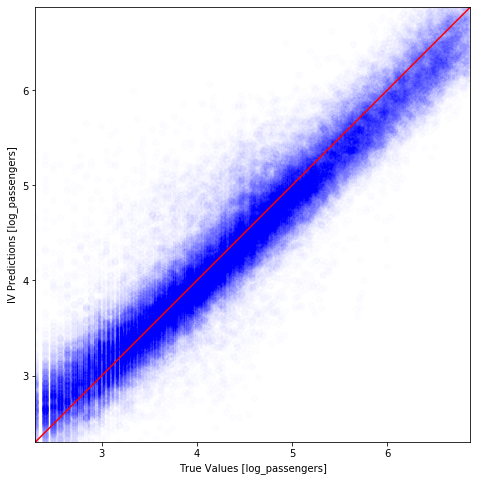

In [85]:
fig, ax = plt.subplots(figsize=(12,8))

a = plt.axes(aspect='equal')
plt.scatter(panel_df.log_passengers.values, iv2LSmodel.predict().values, alpha=.007, c='b')
plt.xlabel('True Values [log_passengers]')
plt.ylabel('IV Predictions [log_passengers]')

lims = [panel_df.log_passengers.min(), panel_df.log_passengers.max()]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, c='r')


<function matplotlib.pyplot.show(*args, **kw)>

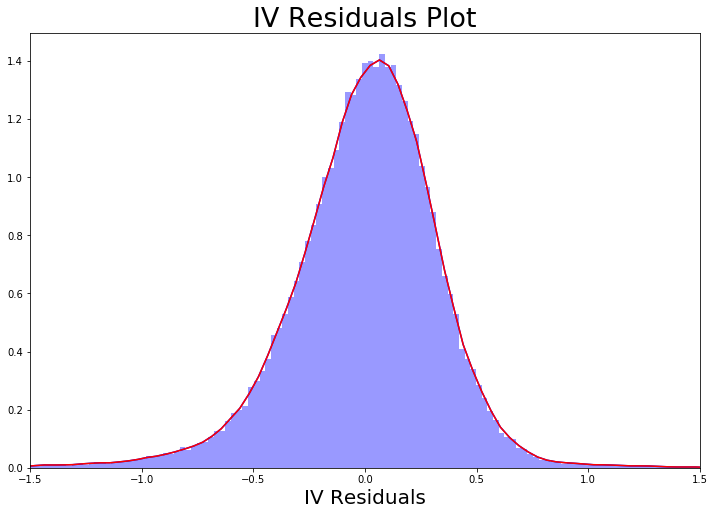

In [86]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.distplot(iv2LSmodel.resids, bins=200, hist=True, kde='gaussian', color='b', ax=ax, norm_hist=True)
sns.distplot(iv2LSmodel.resids, bins=200, hist=False, kde='kernel', color='r', ax=ax, norm_hist=True)
ax.set_title("IV Residuals Plot", fontsize=27)
ax.set_xlim(-1.5,1.5)
ax.set_xlabel('IV Residuals', fontsize=20)

plt.show

## GMM Estimation
> GMM estimation can be more efficient than 2SLS when there are more than one instrument. By default, 2-step efficient GMM is used (assuming the weighting matrix is correctly specified). It is possible to iterate until convergence using the optional keyword input iter_limit, which is naturally 2 by default. Generally, GMM-CUE would be preferred to using multiple iterations of standard GMM. Source: [linearmodels 4.5](https://bashtage.github.io/linearmodels/doc/iv/examples/advanced-examples.html)

### Parameters
- According to the [linearmodels 4.5](https://bashtage.github.io/linearmodels/doc/iv/examples/advanced-examples.html) "available GMM weight functions are:
    - `unadjusted`, 'homoskedastic' - Assumes moment conditions are homoskedastic
    - `robust`, 'heteroskedastic' - Allows for heteroskedasticity by not autocorrelation
    - `kernel` - Allows for heteroskedasticity and autocorrelation
    - `cluster` - Allows for one-way cluster dependence"
- As we have heteroskedasticity and autocorrelation, we use the **`kernel`** option ==>
    - Kernel (HAC)
    - Kernel: bartlett

In [87]:
controls = ['const','log_nsmiles','log_income_capita','log_population','nb_airline',
            'log_kjf_price','dum_dist']

instruements = ['log_nsmiles_dif1','log_income_capita_dif1','log_population_dif1','nb_airline_dif1',
                'log_fare_dif1','log_fare_dif2','log_passengers_dif2',
                'log_nsmiles_dif2','log_income_capita_dif2','log_population_dif2','nb_airline_dif2']

ivgmmmodel = IVGMM(panel_df['log_passengers'],
                   panel_df[controls + dum_period[:-2]],
                   panel_df[['log_fare','log_passengers_lag1']],
                   panel_df[instruements]).fit(cov_type='robust')

print(ivgmmmodel.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:         log_passengers   R-squared:                      0.9308
Estimator:                     IV-GMM   Adj. R-squared:                 0.9308
No. Observations:               84939   F-statistic:                 7.082e+05
Date:                Thu, Jan 16 2020   P-value (F-stat)                0.0000
Time:                        17:33:38   Distribution:                 chi2(36)
Cov. Estimator:                robust                                         
                                                                              
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
const                   7.3589     0.4639     15.863     0.0000      6.4497      8.2682
log_nsmiles     

In [88]:
ivgmmmodel.j_stat

H0: Expected moment conditions are equal to 0
Statistic: 2358.0999
P-value: 0.0000
Distributed: chi2(9)
WaldTestStatistic, id: 0x1c99019438

## Testing Autocorrelation
The regression residuals are not autocorrelated ? See [reference](https://www.statsmodels.org/stable/diagnostic.html)

In [89]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import acorr_breusch_godfrey


### 1. Ljung-Box test for no autocorrelation

In [90]:
ljungbox_test = acorr_ljungbox(ivgmmmodel.resids.values)

In [91]:
ljungbox_test

(array([1.15293636e+01, 4.54944455e+02, 2.48782688e+03, 2.03086009e+04,
        2.07280083e+04, 2.15544809e+04, 2.24086416e+04, 3.17374584e+04,
        3.24324450e+04, 3.27693461e+04, 3.33170271e+04, 3.93500454e+04,
        3.98010636e+04, 4.00625212e+04, 4.06359515e+04, 4.41141296e+04,
        4.43766087e+04, 4.47821189e+04, 4.51244342e+04, 4.70011239e+04,
        4.73350413e+04, 4.76908188e+04, 4.79200411e+04, 4.91149482e+04,
        4.93517658e+04, 4.97202113e+04, 4.99421637e+04, 5.04307818e+04,
        5.07264813e+04, 5.11087428e+04, 5.13670859e+04, 5.16402707e+04,
        5.19073299e+04, 5.22608622e+04, 5.24778985e+04, 5.28599171e+04,
        5.30186457e+04, 5.33943079e+04, 5.35771374e+04, 5.39014563e+04]),
 array([6.85054621e-04, 1.62205962e-99, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000

### 2.  Breusch Godfrey test for no autocorrelation of residuals

In [92]:
from statsmodels.tsa.tsatools import lagmat
from statsmodels.regression.linear_model import OLS
from scipy import stats
name = ['Lagrange multiplier statistic:','Lagrange multiplier P-value:','f_statistic for F test:','P-value for F test:']

### 2.1.  Breusch Godfrey test using GMM results: 
- The following function return the  Breusch Godfrey test. For more details refere to the red lines

In [93]:
def breusch_godfrey_lm(results, nlags=None, store=False):
    """
    Breusch Godfrey Lagrange Multiplier tests for residual autocorrelation
    Parameters:
    ----------
        - results(Result instance): Estimation results for which the residuals are tested for serial correlation
        - nlags(int): Number of lags to include in the auxiliary regression. (nlags is highest lag)
        - store(bool): If store is true, then an additional class instance that contains intermediate results is returned.
    Returns
    -------
        - lm(float): Lagrange multiplier test statistic
        - lmpval(float): p-value for Lagrange multiplier test
        - fval(float): fstatistic for F test, alternative version of the same test based on F test for the parameter restriction
        - fpval(float): pvalue for F test
        - resstore(instance – optional): a class instance that holds intermediate results. Only returned if store=True
    Notes
    -----
    BG adds lags of residual to exog in the design matrix for the auxiliary regression with residuals as endog, see Greene 12.7.1.
    References
    ----------
        - Greene Econometrics, 5th edition
        - https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_breusch_godfrey.html#statsmodels.stats.diagnostic.acorr_breusch_godfrey
    """

    x = np.asarray(results.resids)
    exog_old = results.model.exog.original
    nobs = x.shape[0]
    if nlags is None:
        #for adf from Greene referencing Schwert 1989
        nlags = np.trunc(12. * np.power(nobs/100., 1/4.))#nobs//4  #TODO: check default, or do AIC/BIC
        nlags = int(nlags)

    x = np.concatenate((np.zeros(nlags), x))

    #xdiff = np.diff(x)
    #
    xdall = lagmat(x[:,None], nlags, trim='both')
    nobs = xdall.shape[0]
    xdall = np.c_[np.ones((nobs,1)), xdall]
    xshort = x[-nobs:]
    exog = np.column_stack((exog_old, xdall))
    k_vars = exog.shape[1]

    if store: resstore = ResultsStore()

    resols = OLS(xshort, exog).fit()
    ft = resols.f_test(np.eye(nlags, k_vars, k_vars - nlags))
    fval = ft.fvalue
    fpval = ft.pvalue
    fval = np.squeeze(fval)[()]   #TODO: fix this in ContrastResults
    fpval = np.squeeze(fpval)[()]
    lm = nobs * resols.rsquared
    lmpval = stats.chi2.sf(lm, nlags)
    # Note: degrees of freedom for LM test is nvars minus constant = usedlags
    #return fval, fpval, lm, lmpval

    if store:
        resstore.resols = resols
        resstore.usedlag = nlags
        return lm, lmpval, fval, fpval, resstore
    else:
        return lm, lmpval, fval, fpval

In [94]:
breusch_godfrey_test_gmm = breusch_godfrey_lm(ivgmmmodel)
print(pd.Series(breusch_godfrey_test_gmm, 
                index=name))


Lagrange multiplier statistic:    24302.637078
Lagrange multiplier P-value:          0.000000
f_statistic for F test:             529.058838
P-value for F test:                   0.000000
dtype: float64


### 2.2. Breusch-Pagan test using OLS results
- We use the python algorithm for the step

In [95]:
olsmodel = sm.OLS(panel_df.log_passengers,
                  panel_df[['log_passengers_lag1','pass_lag_resids']+controls+dum_period[:-2]]
                 ).fit()

breusch_godfrey_test_ols = acorr_breusch_godfrey(olsmodel)
print(pd.Series(breusch_godfrey_test_ols, 
                index=name))


Lagrange multiplier statistic:    26077.145491
Lagrange multiplier P-value:          0.000000
f_statistic for F test:             587.275220
P-value for F test:                   0.000000
dtype: float64


# GMM with `Kernel` cov_type option

- This Breusch-Pagan test used on the two results (`GMM` and `OLS`) show that we have autocorrelation.
- Hence, we have to run the `GMM`by taking into account of this `autocorrelation` and the `heteroskedastic` that was alredy test with the `White` and `Breusch–Pagan`. 
- Consequently, the `kernel` `cov_type` option will be used:
    - Kernel (HAC)
    - Kernel: bartlett

In [96]:
controls = ['const','log_nsmiles','log_income_capita','log_population','nb_airline',
            'log_kjf_price','dum_dist']

instruements = ['log_nsmiles_dif1','log_income_capita_dif1','log_population_dif1','nb_airline_dif1',
                'log_fare_dif1','log_fare_dif2','log_passengers_dif2',
                'log_nsmiles_dif2','log_income_capita_dif2','log_population_dif2','nb_airline_dif2']

ivgmmmodel = IVGMM(panel_df['log_passengers'],
                   panel_df[controls + dum_period[:-2]],
                   panel_df[['log_fare','log_passengers_lag1']],
                   panel_df[instruements]).fit(cov_type='kernel')

print(ivgmmmodel.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:         log_passengers   R-squared:                      0.9308
Estimator:                     IV-GMM   Adj. R-squared:                 0.9308
No. Observations:               84939   F-statistic:                 4.921e+06
Date:                Thu, Jan 16 2020   P-value (F-stat)                0.0000
Time:                        17:36:22   Distribution:                 chi2(36)
Cov. Estimator:                kernel                                         
                                                                              
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
const                   7.3589     1.2615     5.8334     0.0000      4.8864      9.8315
log_nsmiles     

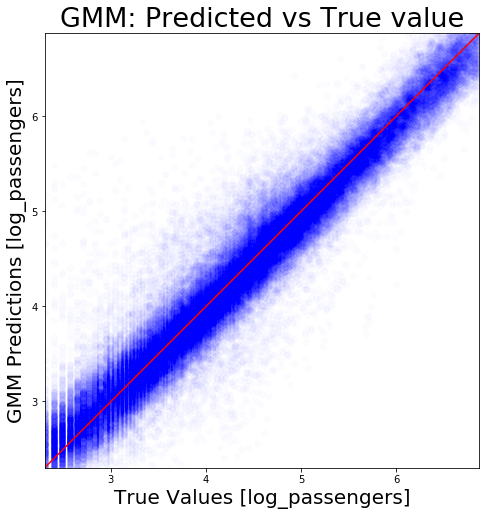

In [97]:
fig, ax = plt.subplots(figsize=(12,8))

a = plt.axes(aspect='equal')
plt.scatter(panel_df.log_passengers.values, ivgmmmodel.predict().values, alpha=.01, c='b')

plt.title("GMM: Predicted vs True value", fontsize=27)
plt.xlabel('True Values [log_passengers]', fontsize=20)
plt.ylabel('GMM Predictions [log_passengers]', fontsize=20)

lims = [panel_df.log_passengers.min(), panel_df.log_passengers.max()]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, c='r')


<function matplotlib.pyplot.show(*args, **kw)>

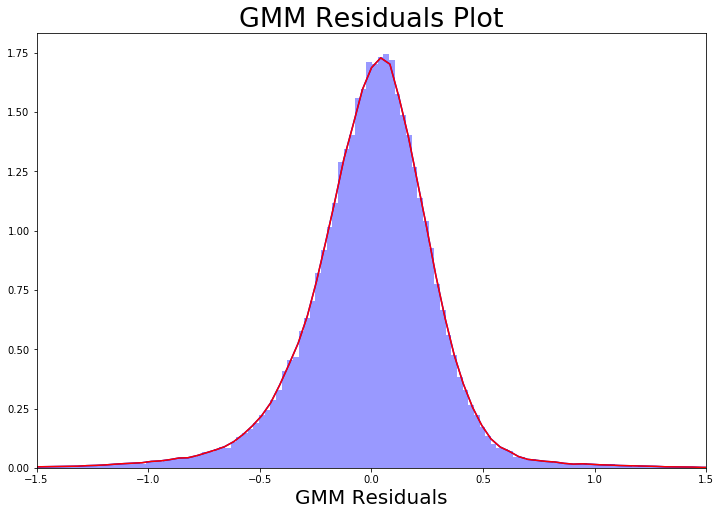

In [98]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.distplot(ivgmmmodel.resids, bins=200, hist=True, kde='gaussian', color='b', ax=ax, norm_hist=True)
sns.distplot(ivgmmmodel.resids, bins=200, hist=False, kde='kernel', color='r', ax=ax, norm_hist=True)
ax.set_title("GMM Residuals Plot", fontsize=27)
ax.set_xlim(-1.5,1.5)
ax.set_xlabel('GMM Residuals', fontsize=20)

plt.show

### 3. Exogeneity Testing using GMM model
The J statistic tests whether the moment conditions are sufficiently close to zero to indicate that the model is not overidentified.   
The statistic is defined as  $\bar{g}'W^{-1}\bar{g} \sim \chi^2_q$

In [99]:
ivgmmmodel.j_stat

H0: Expected moment conditions are equal to 0
Statistic: 2358.0999
P-value: 0.0000
Distributed: chi2(9)
WaldTestStatistic, id: 0x1c9900f978

### 4. Exogeneity test using the augmented regression approach
Estimating the variances of u(i), assuming that sigma2(ui)=exp(a0+a1*log_fare+a2*log_nsmiles)
- Regress using OLS the `log square of the IV residuals`
- Compute `inverse of sigma` using the the square root of the exponentiel of the fitted values

### 4.1. Use the `IV2SL` `residuals` as reponse variable in the `OLS` model and compute the `inverse of the sigma`

In [100]:
controls = ['const','log_nsmiles','log_income_capita','log_population','nb_airline',
            'log_kjf_price','dum_dist']

instruements = ['log_nsmiles_dif1','log_income_capita_dif1','log_population_dif1','nb_airline_dif1',
                'log_fare_dif1','log_fare_dif2','log_passengers_dif2',
                'log_nsmiles_dif2','log_income_capita_dif2','log_population_dif2','nb_airline_dif2']

iv2LSmodel = IV2SLS(panel_df['log_passengers'], 
                    panel_df[controls+dum_period[:-2]], 
                    panel_df[['log_fare','log_passengers_lag1']], panel_df[instruements]).fit()


In [101]:
panel_df['log_iv_residus2'] = np.log(iv2LSmodel.resids**2)

r2_aug = PanelOLS(panel_df.log_iv_residus2, panel_df[['log_fare','log_passengers_lag1']]).fit(cov_type='robust')

# computes 1/sigma to be used later as weight for correcting for heteroskedasticity
sigma_inverse = 1/(np.exp(r2_aug.predict())**.5) #  np.sqrt()

### 4.2. Feasible Generalized Least Squares (GLS)
GLS on the augmented regression  = Exogeneity test for "log_fare" allowing for heteroskedasticity

In [102]:
glsmodel = sm.GLS(panel_df['log_passengers'], panel_df[controls+['log_fare','log_passengers_lag1']+dum_period[:-2]], sigma=sigma_inverse).fit()
print(glsmodel.summary())

                            GLS Regression Results                            
Dep. Variable:         log_passengers   R-squared:                       0.941
Model:                            GLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 3.732e+04
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        17:36:26   Log-Likelihood:                -11860.
No. Observations:               84939   AIC:                         2.379e+04
Df Residuals:                   84902   BIC:                         2.414e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.1190    

In [103]:
glsmodel.params[:9]

const                  6.118969
log_nsmiles            0.050671
log_income_capita      0.046950
log_population         0.006499
nb_airline             0.024737
log_kjf_price         -1.187676
dum_dist              -0.052914
log_fare              -0.111421
log_passengers_lag1    0.935017
dtype: float64

In [104]:
glsmodel.bse[:9]

const                  0.419058
log_nsmiles            0.001871
log_income_capita      0.010968
log_population         0.001576
nb_airline             0.000604
log_kjf_price          0.076989
dum_dist               0.010289
log_fare               0.003423
log_passengers_lag1    0.001155
dtype: float64

### 4.3. GLSA model
We can use the GLSAR model with one lag, to get to a similar result:

In [105]:
glsarmodel = sm.GLSAR(panel_df['log_passengers'], panel_df[controls+['log_fare','log_passengers_lag1']+dum_period[:-2]], 1)
glsarresults = glsarmodel.iterative_fit(1)
print(glsarresults.summary())

                           GLSAR Regression Results                           
Dep. Variable:         log_passengers   R-squared:                       0.942
Model:                          GLSAR   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                 3.816e+04
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        17:36:26   Log-Likelihood:                -10797.
No. Observations:               84938   AIC:                         2.167e+04
Df Residuals:                   84901   BIC:                         2.201e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.2079    

In [106]:
glsarresults.params[:9]

const                  6.207915
log_nsmiles            0.053186
log_income_capita      0.045766
log_population         0.007043
nb_airline             0.024898
log_kjf_price         -1.193759
dum_dist              -0.052464
log_fare              -0.124391
log_passengers_lag1    0.934516
dtype: float64

In [107]:
glsarresults.bse[:9]

const                  0.414537
log_nsmiles            0.001857
log_income_capita      0.010837
log_population         0.001563
nb_airline             0.000599
log_kjf_price          0.076159
dum_dist               0.010554
log_fare               0.003618
log_passengers_lag1    0.001154
dtype: float64

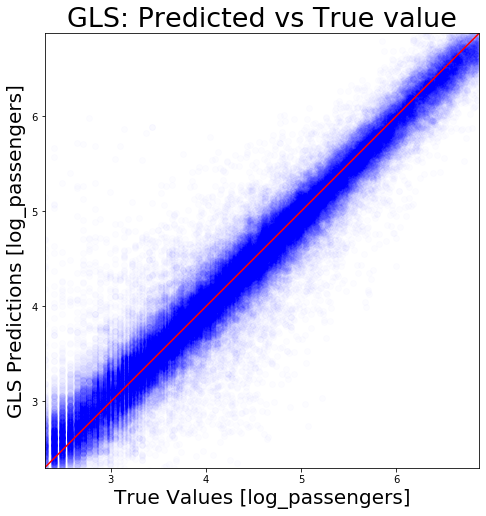

In [108]:
fig, ax = plt.subplots(figsize=(12,8))

ax = plt.axes(aspect='equal')
ax.scatter(panel_df.log_passengers.values, glsmodel.predict(), alpha=.01, c='b')
plt.title("GLS: Predicted vs True value", fontsize=27)
plt.xlabel('True Values [log_passengers]', fontsize=20)
plt.ylabel('GLS Predictions [log_passengers]', fontsize=20)

lims = [panel_df.log_passengers.min(), panel_df.log_passengers.max()]
ax.set_xlim(lims)
ax.set_ylim(lims)
_ = ax.plot(lims, lims, c='r')


<function matplotlib.pyplot.show(*args, **kw)>

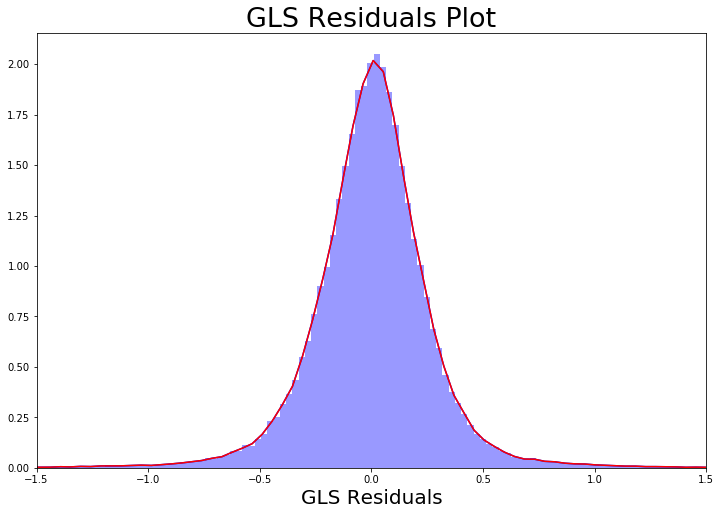

In [109]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.distplot(glsmodel.resid, bins=200, hist=True, kde='gaussian', color='b', ax=ax, norm_hist=True)
sns.distplot(glsmodel.resid, bins=200, hist=False, kde='kernel', color='r', ax=ax, norm_hist=True)
ax.set_title("GLS Residuals Plot", fontsize=27)
ax.set_xlim(-1.5,1.5)
ax.set_xlabel('GLS Residuals', fontsize=20)

plt.show

> GLS is the model that takes autocorrelated residuals into account, [source](https://stats.stackexchange.com/questions/254505/autocorrelation-and-gls)

## References  
StatsModels – Regression Diagnostics and Specification: https://www.statsmodels.org/stable/diagnostic.html  
Linearmodel 4.14 – Examples: https://bashtage.github.io/linearmodels/devel/panel/examples/examples.html  
Linearmodel 4.5 – Examples: https://bashtage.github.io/linearmodels/doc/panel/examples/examples.html?highlight=white  
Linearmodel 4.5 – Linear Instrumental-Variables Regression:https://bashtage.github.io/linearmodels/doc/iv/examples/advanced-examples.html  
PDF – Heteroskedasticity and Autocorrelation: http://www.homepages.ucl.ac.uk/~uctpsc0/Teaching/GR03/Heter&Autocorr.pdf  
PDF – (Orleans) Linear Panel Models and Heterogeneity: https://www.univ-orleans.fr/deg/masters/ESA/CH/Geneve_Chapitre1.pdf  
PDF - Panel Data Models with Heterogeneity and Endogeneity https://www.ifs.org.uk/docs/wooldridge%20session%204.pdf  
PDF – Instrumental Variables Estimation: http://www3.grips.ac.jp/~yamanota/Lecture%20Note%208%20to%2010%202SLS%20&%20others.pdf  
Generalized Least Squares: https://www.statsmodels.org/dev/examples/notebooks/generated/gls.html  
Endogenous Variables and IV Regression in Python: https://bfdykstra.github.io/2016/11/17/Endogeneity-and-Instrumental-Variable-Regression.html?fbclid=IwAR2yWXJKHUzcvqhhdX_yo4l5bn0uEa9CK09T5j9XmhCQxPKC_IIXJPdm45s  

PDF – P.3 Economics 241B Estimation with Instruments: http://econ.ucsb.edu/~doug/241b/Lectures/16%20Estimation%20with%20Instruments.pdf  
PDF: HOW TO TEST ENDOGENEITY OR EXOGENEITY: AN E-LEARNING HANDS ON SAS: http://www.kiran.nic.in/pdf/Social_Science/e-learning/How_to_Test_Endogeneity_or_Exogeneity_using_SAS-1.pdf